In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data/personality_dataset.csv")

# Display basic information about the dataset
print(df.info())
print(df.head())
print(df.describe(include='all'))

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB
None
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate target variable
X = df.drop("Personality", axis=1)
y = df["Personality"]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(include=["float64", "int64"]).columns

# Preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Original X shape: {X.shape}")
print(f"Processed X shape: {X_processed.shape}")
print(f"Original y shape: {y.shape}")
print(f"Encoded y shape: {y_encoded.shape}")
print("Sample of encoded y:", y_encoded[:5])
print("Sample of processed X (first 5 rows, first 5 columns):\n", X_processed[:5, :5])

Original X shape: (2900, 7)
Processed X shape: (2900, 9)
Original y shape: (2900,)
Encoded y shape: (2900,)
Sample of encoded y: [0 1 1 0 0]
Sample of processed X (first 5 rows, first 5 columns):
 [[ 4.  4.  6. 13.  5.]
 [ 9.  0.  0.  0.  3.]
 [ 9.  1.  2.  5.  2.]
 [ 0.  6.  7. 14.  8.]
 [ 3.  9.  4.  8.  5.]]


In [ ]:
# pip install scikit-learn


     ---------------------------------------- 10.7/10.7 MB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 41.2/41.2 MB 4.5 MB/s eta 0:00:00
  Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import numpy as np

# Define the preprocessor (update according to your pipeline)
# Example: Assuming 'preprocessor' is already defined as part of your pipeline
# preprocessor = ... 

# Hyperparameter grid for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False],
}

# Create the pipeline with preprocessing and classifier
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters and the corresponding model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

# Evaluate the model on the training set
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("\nTraining Set Evaluation:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\nTesting Set Evaluation:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("Confusion Matrix:\n", test_conf_matrix)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

Training Set Evaluation:
Accuracy: 0.9366
Precision: 0.9368
Recall: 0.9366
F1-Score: 0.9366

Testing Set Evaluation:
Accuracy: 0.9293
Precision: 0.9296
Recall: 0.9293
F1-Score: 0.9293
Confusion Matrix:
 [[278  24]
 [ 17 261]]


In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Define models and their hyperparameter grids
models_and_params = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    },
    
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        }
    },
    
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    }
}

# Store results
results = {}

# Perform hyperparameter tuning for each model
for model_name, model_info in models_and_params.items():
    print(f"\n{'='*50}")
    print(f"Tuning {model_name}...")
    print(f"{'='*50}")
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        cv=5,  # 5-fold cross-validation
        scoring='accuracy',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Store results
    results[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'grid_search': grid_search
    }
    
    print(f"Best parameters for {model_name}:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Compare all models
print(f"\n{'='*60}")
print("MODEL COMPARISON")
print(f"{'='*60}")

best_model_name = None
best_score = 0

for model_name, result in results.items():
    cv_score = result['best_cv_score']
    print(f"{model_name:20} | CV Score: {cv_score:.4f}")
    
    if cv_score > best_score:
        best_score = cv_score
        best_model_name = model_name

print(f"\nBest performing model: {best_model_name} (CV Score: {best_score:.4f})")

# Evaluate the best model on test set
best_model = results[best_model_name]['best_estimator']
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\n{'='*60}")
print(f"FINAL EVALUATION - {best_model_name}")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Cross-validation Score: {best_score:.4f}")

# Detailed classification report
print(f"\nClassification Report:")
target_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    print(f"\nTop 10 Most Important Features:")
    feature_importance = best_model.feature_importances_
    # Get feature names after preprocessing
    feature_names = []
    
    # Add numerical feature names
    feature_names.extend(numerical_cols.tolist())
    
    # Add categorical feature names (after one-hot encoding)
    if len(categorical_cols) > 0:
        cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
        feature_names.extend(cat_feature_names.tolist())
    
    # Sort features by importance
    importance_indices = np.argsort(feature_importance)[::-1]
    
    for i in range(min(10, len(feature_names))):
        idx = importance_indices[i]
        print(f"  {i+1:2d}. {feature_names[idx]:30} | Importance: {feature_importance[idx]:.4f}")

Training set shape: (2320, 9)
Test set shape: (580, 9)

Tuning Random Forest...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters for Random Forest:
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100
Best cross-validation score: 0.9388

Tuning Gradient Boosting...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Gradient Boosting:
  learning_rate: 0.05
  max_depth: 3
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100
Best cross-validation score: 0.9384

Tuning SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for SVM:
  C: 0.1
  gamma: scale
  kernel: rbf
Best cross-validation score: 0.9388

Tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for Logistic Regression:
  C: 0.01
  penalty: l1
  solver: liblinear
Best cross-validation score: 0.9388

MODEL COMPARISON
Random F


📊 Model Evaluation Summary – Random Forest
✅ Test Accuracy : 0.9138
🎯 F1 Score      : 0.9135
🎯 Precision     : 0.8919
🎯 Recall        : 0.9362
🔍 Best CV Score : 0.9388


c:\Users\pcadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\pcadmin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


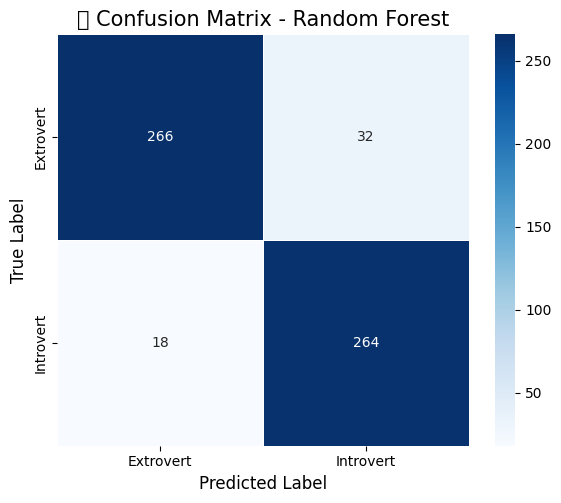

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the selected best model
best_model = results[best_model_name]['best_estimator']
y_pred = best_model.predict(X_test)

# Compute detailed metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# 🎯 Display Model Info
print("\n" + "="*60)
print(f"📊 Model Evaluation Summary – {best_model_name}")
print("="*60)
print(f"✅ Test Accuracy : {acc:.4f}")
print(f"🎯 F1 Score      : {f1:.4f}")
print(f"🎯 Precision     : {prec:.4f}")
print(f"🎯 Recall        : {recall:.4f}")
print(f"🔍 Best CV Score : {results[best_model_name]['best_cv_score']:.4f}")
print("="*60)

# 🔵 Confusion Matrix – Styled & Colored
plt.figure(figsize=(6, 5))
plt.title(f'🔍 Confusion Matrix - {best_model_name}', fontsize=15)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, cmap='Blues', square=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [28]:
# Tabular output of classification metrics
import pandas as pd

metrics_df = pd.DataFrame({
    "Metric": ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'CV Score'],
    "Score": [acc, f1, prec, recall, results[best_model_name]['best_cv_score']]
})

# Round values
metrics_df['Score'] = metrics_df['Score'].apply(lambda x: f"{x:.4f}")

# Display nicely
print("\n📋 Evaluation Metrics Table:\n")
print(metrics_df.to_string(index=False))


📋 Evaluation Metrics Table:

   Metric  Score
 Accuracy 0.9138
 F1 Score 0.9135
Precision 0.8919
   Recall 0.9362
 CV Score 0.9388


In [ ]:
pip install seaborn

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import pickle
import joblib

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Define models and their hyperparameter grids
models_and_params = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    },
    
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        }
    },
    
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    }
}

# Store detailed results
detailed_results = {}
accuracy_comparison = []

# Perform hyperparameter tuning for each model
for model_name, model_info in models_and_params.items():
    print(f"\n{'='*60}")
    print(f"TUNING {model_name.upper()}")
    print(f"{'='*60}")
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate various metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    cv_accuracy = grid_search.best_score_
    
    # Calculate additional metrics (using weighted average for multiclass)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Store detailed results
    detailed_results[model_name] = {
        'best_estimator': best_model,
        'best_params': grid_search.best_params_,
        'cv_accuracy': cv_accuracy,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'y_pred': y_test_pred,
        'grid_search': grid_search
    }
    
    # Store for comparison table
    accuracy_comparison.append({
        'Model': model_name,
        'CV_Accuracy': cv_accuracy,
        'Train_Accuracy': train_accuracy,
        'Test_Accuracy': test_accuracy,
        'Test_Precision': test_precision,
        'Test_Recall': test_recall,
        'Test_F1': test_f1,
        'Overfitting': train_accuracy - test_accuracy
    })
    
    print(f"\n📊 {model_name} Results:")
    print(f"   Best Parameters: {grid_search.best_params_}")
    print(f"   Cross-Validation Accuracy: {cv_accuracy:.4f}")
    print(f"   Training Accuracy: {train_accuracy:.4f}")
    print(f"   Test Accuracy: {test_accuracy:.4f}")
    print(f"   Test Precision: {test_precision:.4f}")
    print(f"   Test Recall: {test_recall:.4f}")
    print(f"   Test F1-Score: {test_f1:.4f}")
    print(f"   Overfitting (Train-Test): {train_accuracy - test_accuracy:.4f}")

# Create comprehensive comparison DataFrame
comparison_df = pd.DataFrame(accuracy_comparison)
comparison_df = comparison_df.round(4)

print(f"\n{'='*100}")
print("COMPREHENSIVE MODEL COMPARISON")
print(f"{'='*100}")
print(comparison_df.to_string(index=False))

# Find best model based on different criteria
best_cv_model = comparison_df.loc[comparison_df['CV_Accuracy'].idxmax(), 'Model']
best_test_model = comparison_df.loc[comparison_df['Test_Accuracy'].idxmax(), 'Model']
best_f1_model = comparison_df.loc[comparison_df['Test_F1'].idxmax(), 'Model']
least_overfitting = comparison_df.loc[comparison_df['Overfitting'].idxmin(), 'Model']

print(f"\n{'='*100}")
print("BEST MODELS BY DIFFERENT CRITERIA")
print(f"{'='*100}")
print(f"🏆 Best CV Accuracy:        {best_cv_model} ({comparison_df[comparison_df['Model']==best_cv_model]['CV_Accuracy'].values[0]:.4f})")
print(f"🏆 Best Test Accuracy:      {best_test_model} ({comparison_df[comparison_df['Model']==best_test_model]['Test_Accuracy'].values[0]:.4f})")
print(f"🏆 Best F1-Score:           {best_f1_model} ({comparison_df[comparison_df['Model']==best_f1_model]['Test_F1'].values[0]:.4f})")
print(f"🏆 Least Overfitting:       {least_overfitting} ({comparison_df[comparison_df['Model']==least_overfitting]['Overfitting'].values[0]:.4f})")

# Select the best model (you can change the selection criteria)
# Using test accuracy as the primary criterion
selected_model_name = best_test_model
selected_model_results = detailed_results[selected_model_name]

print(f"\n{'='*100}")
print(f"SELECTED MODEL: {selected_model_name}")
print(f"{'='*100}")

selected_model = selected_model_results['best_estimator']
selected_params = selected_model_results['best_params']

print(f"Selected based on: Highest Test Accuracy")
print(f"Test Accuracy: {selected_model_results['test_accuracy']:.4f}")
print(f"CV Accuracy: {selected_model_results['cv_accuracy']:.4f}")
print(f"F1-Score: {selected_model_results['test_f1']:.4f}")

print(f"\nOptimized Parameters:")
for param, value in selected_params.items():
    print(f"  {param}: {value}")

# Detailed analysis for selected model
print(f"\n{'='*100}")
print(f"DETAILED ANALYSIS - {selected_model_name}")
print(f"{'='*100}")

# Classification report
target_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(y_test, selected_model_results['y_pred'], target_names=target_names))

# Confusion Matrix
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, selected_model_results['y_pred'])
print(cm)

# Class-wise accuracy
print(f"\nClass-wise Accuracy:")
for i, class_name in enumerate(target_names):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"  {class_name}: {class_accuracy:.4f}")

# Model comparison visualization data
print(f"\n{'='*100}")
print("MODEL RANKING BY DIFFERENT METRICS")
print(f"{'='*100}")

metrics = ['CV_Accuracy', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']
for metric in metrics:
    ranked = comparison_df.nlargest(len(comparison_df), metric)[['Model', metric]]
    print(f"\n🏅 Ranking by {metric}:")
    for idx, (_, row) in enumerate(ranked.iterrows(), 1):
        print(f"  {idx}. {row['Model']:<20} | {row[metric]:.4f}")

# Feature importance (if available)
if hasattr(selected_model, 'feature_importances_'):
    print(f"\n{'='*100}")
    print(f"FEATURE IMPORTANCE - {selected_model_name}")
    print(f"{'='*100}")
    
    feature_importance = selected_model.feature_importances_
    
    # Get feature names after preprocessing
    feature_names = []
    feature_names.extend(numerical_cols.tolist())
    
    if len(categorical_cols) > 0:
        cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
        feature_names.extend(cat_feature_names.tolist())
    
    # Create feature importance DataFrame
    feature_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print(feature_df.head(15).to_string(index=False))

# Save all results
print(f"\n{'='*100}")
print("SAVING RESULTS")
print(f"{'='*100}")

# Save comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("✅ Model comparison saved as 'model_comparison_results.csv'")

# Save detailed results
with open('detailed_model_results.pkl', 'wb') as f:
    pickle.dump(detailed_results, f)
print("✅ Detailed results saved as 'detailed_model_results.pkl'")

# Create a complete pipeline with the selected model
from sklearn.pipeline import Pipeline

complete_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', selected_model)
])

complete_pipeline.fit(X, y_encoded)

# Save the selected model and components
joblib.dump(complete_pipeline, 'best_personality_model_pipeline.pkl')
joblib.dump(selected_model, 'best_personality_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("✅ Model files saved:")
print("   - best_personality_model_pipeline.pkl")
print("   - best_personality_model.pkl")
print("   - preprocessor.pkl")
print("   - label_encoder.pkl")

# Save comprehensive model information
model_info = {
    'selected_model_name': selected_model_name,
    'selection_criteria': 'Highest Test Accuracy',
    'model_comparison': comparison_df.to_dict('records'),
    'best_params': selected_params,
    'performance_metrics': {
        'cv_accuracy': selected_model_results['cv_accuracy'],
        'test_accuracy': selected_model_results['test_accuracy'],
        'test_precision': selected_model_results['test_precision'],
        'test_recall': selected_model_results['test_recall'],
        'test_f1': selected_model_results['test_f1']
    },
    'feature_names': feature_names if 'feature_names' in locals() else None,
    'target_classes': target_names.tolist()
}

with open('comprehensive_model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✅ Comprehensive model info saved as 'comprehensive_model_info.pkl'")

print(f"\n{'='*100}")
print("HYPERPARAMETER TUNING COMPLETE!")
print(f"{'='*100}")
print(f"🏆 Selected Model: {selected_model_name}")
print(f"📊 Test Accuracy: {selected_model_results['test_accuracy']:.4f}")
print(f"📊 F1-Score: {selected_model_results['test_f1']:.4f}")
print(f"💾 All results and models saved successfully!")

# Function to display results summary
def display_results_summary():
    """Display a quick summary of all model results"""
    print(f"\n{'='*80}")
    print("QUICK RESULTS SUMMARY")
    print(f"{'='*80}")
    
    for model_name, results in detailed_results.items():
        print(f"\n{model_name}:")
        print(f"  Test Accuracy: {results['test_accuracy']:.4f}")
        print(f"  CV Accuracy:   {results['cv_accuracy']:.4f}")
        print(f"  F1-Score:      {results['test_f1']:.4f}")
        print(f"  Overfitting:   {results['train_accuracy'] - results['test_accuracy']:.4f}")

# Call the summary function
display_results_summary()

Training set shape: (2320, 9)
Test set shape: (580, 9)

TUNING RANDOM FOREST
Fitting 5 folds for each of 162 candidates, totalling 810 fits

📊 Random Forest Results:
   Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   Cross-Validation Accuracy: 0.9388
   Training Accuracy: 0.9427
   Test Accuracy: 0.9138
   Test Precision: 0.9149
   Test Recall: 0.9138
   Test F1-Score: 0.9138
   Overfitting (Train-Test): 0.0289

TUNING GRADIENT BOOSTING
Fitting 5 folds for each of 72 candidates, totalling 360 fits

📊 Gradient Boosting Results:
   Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   Cross-Validation Accuracy: 0.9384
   Training Accuracy: 0.9388
   Test Accuracy: 0.9172
   Test Precision: 0.9183
   Test Recall: 0.9172
   Test F1-Score: 0.9172
   Overfitting (Train-Test): 0.0216

TUNING SVM
Fitting 5 folds for each of 32 candidates, t

In [ ]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Create the full pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)"""

Accuracy: 0.9224
Precision: 0.9088
Recall: 0.9317
F1-Score: 0.9201
Confusion Matrix:
 [[276  26]
 [ 19 259]]


In [17]:
# Example of making a prediction on new data
# Let's create a sample new data point (ensure it has the same columns as the training data)
new_data = pd.DataFrame([{
    'Time_spent_Alone': 5,
    'Stage_fear': 'No',
    'Social_event_attendance': 3,
    'Going_outside': 7,
    'Drained_after_socializing': 'No',
    'Friends_circle_size': 10,
    'Post_frequency': 6
}])

# Make prediction
new_prediction_encoded = best_model.predict(new_data)
new_prediction_personality = label_encoder.inverse_transform(new_prediction_encoded)

print(f"New data prediction: {new_prediction_personality[0]}")

New data prediction: Extrovert


In [ ]:
# Example of making a prediction on new data
# Let's create a sample new data point (ensure it has the same columns as the training data)
new_data = pd.DataFrame([{
    'Time_spent_Alone': 5,
    'Stage_fear': 'No',
    'Social_event_attendance': 3,
    'Going_outside': 7,
    'Drained_after_socializing': 'No',
    'Friends_circle_size': 10,
    'Post_frequency': 6
}])

# Make prediction
new_prediction_encoded = best_model.predict(new_data)
new_prediction_personality = label_encoder.inverse_transform(new_prediction_encoded)

print(f"New data prediction: {new_prediction_personality[0]}")

New Best Model

In [22]:
new_data = pd.DataFrame([{
    'Time_spent_Alone': 5,
    'Stage_fear': 'No',
    'Social_event_attendance': 3,
    'Going_outside': 7,
    'Drained_after_socializing': 'No',
    'Friends_circle_size': 10,
    'Post_frequency': 6
}])

# Ensure new_data has the same preprocessing applied
new_data_preprocessed = preprocessor.transform(new_data)

# Make prediction
new_prediction_encoded = best_model.predict(new_data_preprocessed)
new_prediction_personality = label_encoder.inverse_transform(new_prediction_encoded)

print(f"New data prediction: {new_prediction_personality[0]}")


New data prediction: Extrovert


In [18]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv("data/personality_dataset.csv")

# Separate features and target variable
X = df.drop(columns=["Personality"])  # Assuming "Personality" is the target column
y_actual = df["Personality"]

# Encode the target variable (if not already encoded)
# Assuming label_encoder was used earlier for encoding the "Personality" column
y_encoded_actual = label_encoder.transform(y_actual)

# Make predictions on the entire dataset
y_pred_encoded = best_model.predict(X)

# Decode the predictions to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Add the predictions as a new column to the DataFrame
df["Predicted"] = y_pred

# Save the updated DataFrame to a new CSV file
df.to_csv("data/personality_dataset_with_predictions.csv", index=False)

# Calculate and display accuracy
accuracy = accuracy_score(y_actual, y_pred)
print(f"Accuracy on the entire dataset: {accuracy:.4f}")

# Optionally, print the first few rows to verify the output
print(df.head())


Accuracy on the entire dataset: 0.9352
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  \
0                        No                 13.0             5.0   Extrovert   
1                       Yes                  0.0             3.0   Introvert   
2                       Yes                  5.0             2.0   Introvert   
3                        No                 14.0             8.0   Extrovert   
4                        No                  8.0             5.0   Extrovert   

   Predicted  
0  Extrovert  
1  In

In [31]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import joblib

# 📂 Load saved pipeline & label encoder
pipeline = joblib.load('best_personality_model_pipeline.pkl')
label_encoder = joblib.load('label_encoder.pkl')  # Used to decode prediction outputs

# 📄 Load raw dataset (same format used during training)
df = pd.read_csv("data/personality_dataset.csv")

# 🎯 Separate features and target
X = df.drop(columns=["Personality"])
y_actual = df["Personality"]

# 🔁 Encode actual target using label encoder
y_encoded_actual = label_encoder.transform(y_actual)

# ✅ Predict using full pipeline with preprocessing included
y_pred_encoded = pipeline.predict(X)

# 🔁 Decode predictions back to original "Introvert"/"Extrovert"
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# ➕ Add predictions to the original DataFrame
df["Predicted"] = y_pred

# 💾 Save to a new CSV
output_path = "data/personality_dataset_with_predictions2.csv"
df.to_csv(output_path, index=False)
print(f"✅ Predictions saved to: {output_path}")

# 📊 Evaluate accuracy & display classification report
accuracy = accuracy_score(y_actual, y_pred)
print("\n📈 Model Evaluation on Full Dataset")
print("----------------------------------------")
print(f"✅ Accuracy: {accuracy:.4f}\n")
print("🔍 Classification Report:")
print(classification_report(y_actual, y_pred, target_names=label_encoder.classes_))

# 🧾 Sample preview
print("\n🔢 Sample Predictions:")
print(df[['Personality', 'Predicted']].head())

✅ Predictions saved to: data/personality_dataset_with_predictions2.csv

📈 Model Evaluation on Full Dataset
----------------------------------------
✅ Accuracy: 0.9345

🔍 Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.95      0.93      0.94      1491
   Introvert       0.92      0.94      0.93      1409

    accuracy                           0.93      2900
   macro avg       0.93      0.93      0.93      2900
weighted avg       0.93      0.93      0.93      2900


🔢 Sample Predictions:
  Personality  Predicted
0   Extrovert  Extrovert
1   Introvert  Introvert
2   Introvert  Introvert
3   Extrovert  Extrovert
4   Extrovert  Extrovert
